- University: University of São Paulo (USP) 

- Class: PMR3508 (2021) - Fundamentals of Machine Learning

- Kaggle Competition: Adult

# Table of contents
1. [Setup and imports](#Setup-and-imports)
    1. [Libraries](##Libraries)
    2. [Setup](##Setup)
2. [EDA (Exploratory Data Analysis)](#EDA(Exploratory-Data-Analysis))
    1. [Glance at data](##Glance-at-data)
        1. [Train dataset](###Train-dataset)
        2. [Test dataset](###Test-dataset)
    2. [Summary statistics](##Summary-statistics)
    3. [Target histogram](##Target-histogram)
    4. [Non zero counts](##Non-zero-counts)
    5. [Empirical distribution of features](##Empirical-distribution-of-features)
        1. [Train dataset](###Train-dataset)
            1. [Histograms of numerical features](####Histograms-of-numerical-features)
            2. [Bar plots for categorical features](####Barplots-for-categorical-features)
        2. [Test dataset](###Test-dataset)
            1. [Histograms of numerical features](####Histograms-of-numerical-features)
            2. [Bar plots for categorical features](####Barplots-for-categorical-features)
        3. [Plots of target vs features](###Plots-of-target-vs-features)
            1. [Numerical features](####Numerical-features)
            2. [Categorical features](####Categorical-features)
        4. [Pairwise plots](###Pairwise-plots)
            1. [Scatter plot](####Numerical-vs-numerical)
            2. [Correlation heatmap](####Correlation-heatmap)
            3. [Categorical heatmap](####Categorical-heatmap)
3. [Data engineering](#Data-engineering)
    1. [Divide dataset into numerical and categorical subdatasets](##Divide-dataset-into-numerical-and-categorical-subdatasets)
    1. [Normalize features](##Normalize-features)
    2. [Treat categorical features](##Treat-categorical-features)
    3. [Joining numerical and categorical dfs back](##Joining-numerical-and-categorical-dfs-back)
    4. [Treat missing values](##Treat-missing-values)
    5. [Treat outliers](##Treat-outliers)
    6. [Feature tranformations](##Feature-tranformations)
    7. [Mirror on test dataset](##Mirror-on-testdataset)
4. [Feature Engineering](#Featur-engineering)
    1. [Importance sampling](##Importance-sampling)
    2. [Select features](##Select-features)
    3. [Create new features](##Create-new-features)
5. [Experiments](#Experiments)
    1. [Base dataset](##Base-dataset)
    2. [Baseline](##Baseline)
    3. [Hyperparameter tuning](##Hyperparameter-tuning)
        1. [Neighbors parameter](###Neighbors-parameter)
        2. [Distance type parameter](###Distance-type-parameter)
        3. [Distance weights parameters](###Distance-weights-parameters)
        4. [Neighbors parameter](###Neighbors-parameter)
    4. [Engineered datasets](##Engineered-datasets)
6. [Final model](#Final-model)
7. [Submission](#Submission)

# Setup and imports
### Setup environment and import libraries.

## Libraries

In [1]:
# Just because I have a conflicting Python 3.6 installation at root
# Comment this when uploading to kaggle
# try:
#     sys.path.remove('C:/Python36/Lib/site-packages')
# except:
#     print("sys.path already ok")
    
import sys
import copy

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

sys.path already ok


## Setup

In [2]:
%matplotlib inline
sns.set()

# Loading data
adultTrain = pd.read_csv(
    "C:/Users/bruno/Desktop/kaggle-adult-comp-knn/data/train_data.csv",
    sep=r'\s*,\s*',
    engine='python',
    na_values="?",
)

# # For uploading to kaggle
# adultTrain = pd.read_csv(
#     "/kaggle/input/adult-pmr3508/train_data.csv",
#     sep=r'\s*,\s*',
#     engine='python',
#     na_values="?",
# )

adultTest = pd.read_csv(
    "C:/Users/bruno/Desktop/kaggle-adult-comp-knn/data/test_data.csv",
    sep=r'\s*,\s*',
    engine='python',
    na_values="?",
)

# # For uploading to kaggle
# adultTest = pd.read_csv(
#     "/kaggle/input/adult-pmr3508/test_data.csv",
#     sep=r'\s*,\s*',
#     engine='python',
#     na_values="?",
# )

modifyNames = {
    "fnlwgt": "weight",
    "education.num": "educationNum", 
    "marital.status": "maritalStatus",
    "capital.gain": "capitalGain", 
    "capital.loss": "capitalLoss",
    "hours.per.week": "hoursPerWeek", 
    "native.country": "country",
    "income": "target"
}

# Changing columns names
adultTrain.rename(columns=modifyNames, inplace=True)
adultTest.rename(columns=modifyNames, inplace=True)

# Casting appropriate datatypes
dtypes = {
    "age": int,
    "workclass": str,
    "weight": int,             
    "education": str,
    "educationNum": int,
    "maritalStatus": str,
    "occupation": str,
    "relationship": str,
    "race": str,
    "sex": str,
    "capitalGain": int,
    "capitalLoss": int,
    "hoursPerWeek": int,
    "country": str,
    "target": str
}

adultTrain.astype(dtypes, copy=False)
adultTest.astype(dtypes.pop("target"), copy=False)

# Id is not relevant, so it is dropped
adultTrain.pop("Id")
idTest = adultTest.pop("Id")

# weight is not important for testing
weightTrain = adultTrain["weight"]
adultTest.pop("weight")

# IMPORTANT: need to take levararge of weights by scaling datapoint features!

print("\n\n#### TRAIN DATASET ####")
# (32560, 16)
print('\nshape: ', adultTrain.shape)
# all as objects, need to change some datatypes
print('\ndata types:\n', adultTrain.dtypes)
# max of 4000 datapoints with some nan entry -> treat them
print('\nNumber of null entries:\n', adultTrain.isnull().sum())
# No duplicated data points
print('\nDuplicated data points:\n', adultTrain.duplicated().sum()) 

print("\n\n#### TEST DATASET ####")
# (16280, 15)
print('\nshape: ', adultTest.shape)
# all as objects, need to change some datatypes
print('\ndata types:\n', adultTest.dtypes)
# max of aprox 2000 datapoints with some nan entry -> treat them
print('\nNumber of null entries:\n', adultTest.isnull().sum())
# No duplicated data points
print('\nDuplicated data points:\n', adultTest.duplicated().sum()) 



#### TRAIN DATASET ####

shape:  (32560, 15)

data types:
 age               int64
workclass        object
weight            int64
education        object
educationNum      int64
maritalStatus    object
occupation       object
relationship     object
race             object
sex              object
capitalGain       int64
capitalLoss       int64
hoursPerWeek      int64
country          object
target           object
dtype: object

Number of null entries:
 age                 0
workclass        1836
weight              0
education           0
educationNum        0
maritalStatus       0
occupation       1843
relationship        0
race                0
sex                 0
capitalGain         0
capitalLoss         0
hoursPerWeek        0
country           583
target              0
dtype: int64

Duplicated data points:
 24


#### TEST DATASET ####

shape:  (16280, 13)

data types:
 age               int64
workclass        object
education        object
educationNum      int64
maritalStat

# EDA (Exploratory Data Analysis)
### Get to know data and draw insights on the problem of classifying income as > 50K.

## Glance at data

### Train dataset

In [3]:
# education can be dropped, since educationNum is givving all the information we want
# there is notinh specific about a certain degree that will affect the target
adultTrain.head(20)

,age,workclass,weight,education,educationNum,maritalStatus,occupation,relationship,race,sex,capitalGain,capitalLoss,hoursPerWeek,country,target
0,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
1,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
2,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
3,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K
5,57,Private,163047,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,38,United-States,<=50K
6,21,Private,197050,Some-college,10,Never-married,Other-service,Own-child,White,Female,0,0,35,United-States,<=50K
7,25,Private,288519,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
8,53,Private,260106,HS-grad,9,Widowed,Sales,Not-in-family,White,Female,0,0,30,United-States,<=50K
9,30,Private,213722,HS-grad,9,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,40,United-States,<=50K


### Test dataset

In [4]:
adultTest.head(10)

,age,workclass,education,educationNum,maritalStatus,occupation,relationship,race,sex,capitalGain,capitalLoss,hoursPerWeek,country
0,25,Private,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,44,United-States
1,64,State-gov,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States
2,31,Private,Masters,14,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States
3,45,Private,HS-grad,9,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,40,United-States
4,64,Self-emp-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States
5,24,NaN,HS-grad,9,Never-married,NaN,Not-in-family,Black,Male,0,0,60,United-States
6,40,Self-emp-not-inc,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States
7,40,Private,Doctorate,16,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States
8,29,Private,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,55,United-States
9,36,Private,Bachelors,13,Divorced,Adm-clerical,Unmarried,Black,Female,0,0,40,United-States


## Summary statistics

In [5]:
adultTrain.describe()

,age,weight,educationNum,capitalGain,capitalLoss,hoursPerWeek
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


##  Target histogram

3.152531564851422


<AxesSubplot:>

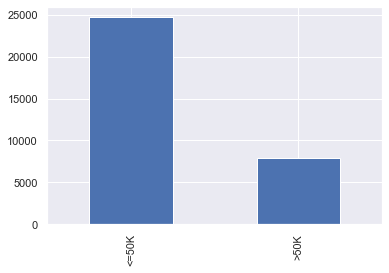

In [6]:
# aprox 25 000 datapoints <= 50K and 7 500 < 50K -> relatively imbalanced dataset
# most simple baseline is prediciting always <= 50K -> gives 0.76% accuracy
counts = adultTrain["target"].value_counts().values
imbalanceRatio = counts[0]/counts[1]
print(imbalanceRatio)
adultTrain["target"].value_counts().plot(kind="bar")


## Non zero counts

In [7]:
# capitalGain and capitalLoss have very few examples
# ideas
    # 1. exclude these festures
    # 2. cluster them in two bins -> will become boolean variables
print(adultTrain.astype(bool).sum(axis=0))

age              32560
workclass        32560
weight           32560
education        32560
educationNum     32560
maritalStatus    32560
occupation       32560
relationship     32560
race             32560
sex              32560
capitalGain       2711
capitalLoss       1519
hoursPerWeek     32560
country          32560
target           32560
dtype: int64


## Plot empirical distribution of each feature

### Train dataset

#### Histograms of numerical features

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'weight'}>],
       [<AxesSubplot:title={'center':'educationNum'}>,
        <AxesSubplot:title={'center':'capitalGain'}>],
       [<AxesSubplot:title={'center':'capitalLoss'}>,
        <AxesSubplot:title={'center':'hoursPerWeek'}>]], dtype=object)

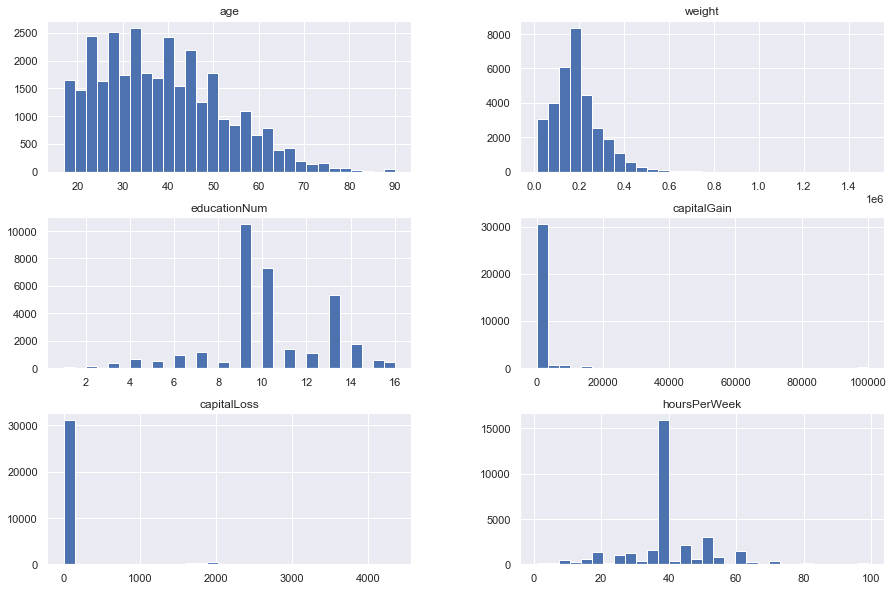

In [8]:
# hoursPerWeek could be dividid in three bins:  <30, 30-50, >50
# educationNUm could be dividid in four bins: <8, 8-10, 10-12, >13
# capitalGains and capitalLoss needs to actuallt only form one feature 
# that is capitalLiquid = capitalGains - capitalLoss. 
# The effect of this feature will be almost as of a imbalanced binary variable since almost all values are zero
# and the other are in a small range
adultTrain.hist(bins=30, figsize=(15, 10))

#### Bar plots for categorical features

"Without-pay" or "Never-worked" datapoints:  14


<AxesSubplot:>

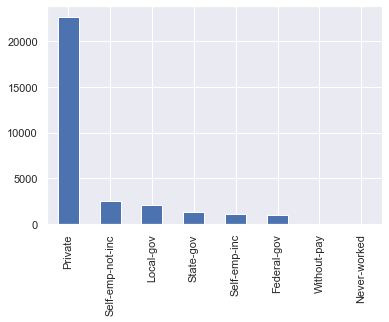

In [9]:
# Private is way bigger than the rest (therefore the rest of the classes have little data)
# Without pay and never work have very few examples (14) but these examples guarantee we know the target
# Ideas:
    # 1. Cluster into 3 bins: private, {without pay + ever worked},  and rest -> 
    # but need to see if private and rest have distinct relatinships with target
print('"Without-pay" or "Never-worked" datapoints: ', adultTrain[adultTrain["workclass"] == ("Without-pay" or "Never-worked")].shape[0])
adultTrain["workclass"].value_counts().plot(kind="bar")

<AxesSubplot:>

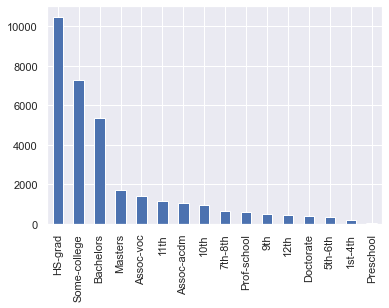

In [10]:
# This feature will be excluded, educationNum already gives us the info we need. There is nothing specific to a 
# certain category that would be relevant for predicting the target
adultTrain["education"].value_counts().plot(kind="bar")

<AxesSubplot:>

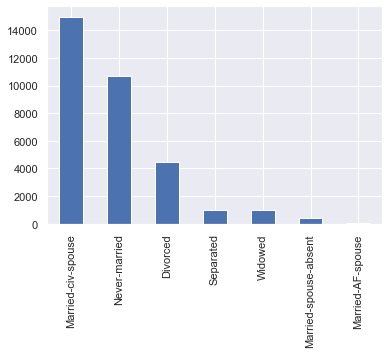

In [11]:
# A priori a would think only having a present spouse or not is important
# So this could be cluster into two groups: present spouse and not present spouse
adultTrain["maritalStatus"].value_counts().plot(kind="bar")

<AxesSubplot:>

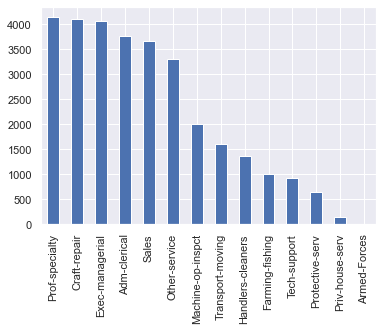

In [12]:
# Each of the categories seem to be very important
adultTrain["occupation"].value_counts().plot(kind="bar")

<AxesSubplot:>

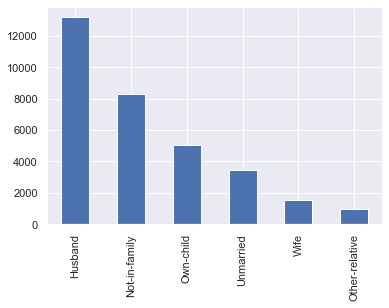

In [13]:
# This feature seem a little weird, it doest provide mmuch new info, 
# and the categories dont seem to be mutually exclusive
# Idea: exclude this feature
adultTrain["relationship"].value_counts().plot(kind="bar")

<AxesSubplot:>

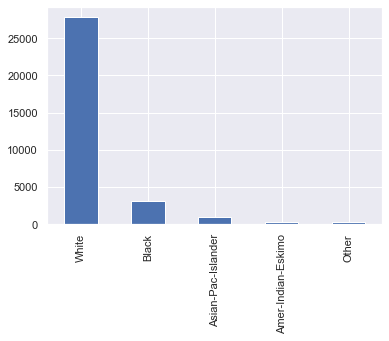

In [14]:
# this could be divided into two bins: white and black 
# because the rest doesnt have data and my guess they would be very similar to white
adultTrain["race"].value_counts().plot(kind="bar")

<AxesSubplot:>

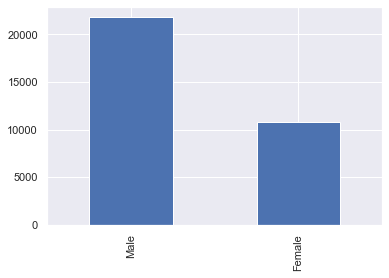

In [15]:
# a priori seems to be important
adultTrain["sex"].value_counts().plot(kind="bar")

<AxesSubplot:>

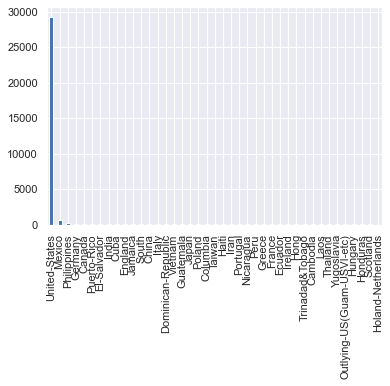

In [16]:
# Surely maintaning all these low data categories will fit statistical noise and ruin the accuracy
# Ideas: 
    # 1. divide in two bins: developed and not developed ccontries
    # 2. divide in two bins: USA and rest
adultTrain["country"].value_counts().plot(kind="bar")

### Test dataset

#### Histograms of numerical features

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'educationNum'}>],
       [<AxesSubplot:title={'center':'capitalGain'}>,
        <AxesSubplot:title={'center':'capitalLoss'}>],
       [<AxesSubplot:title={'center':'hoursPerWeek'}>, <AxesSubplot:>]],
      dtype=object)

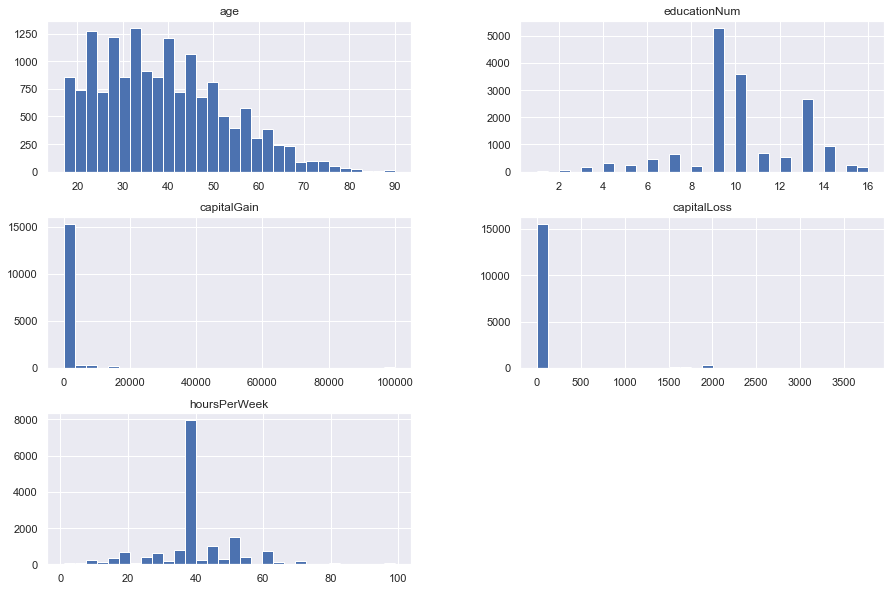

In [17]:
# no surprises here
adultTest.hist(bins=30, figsize=(15, 10))

#### Bar plots for categorical features

<AxesSubplot:>

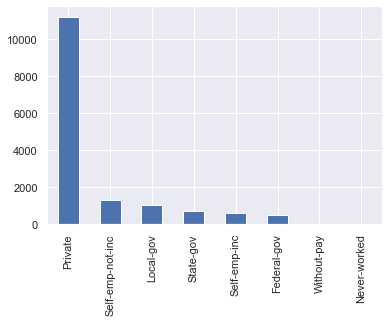

In [18]:
# no surprises here
adultTest["workclass"].value_counts().plot(kind="bar")

<AxesSubplot:>

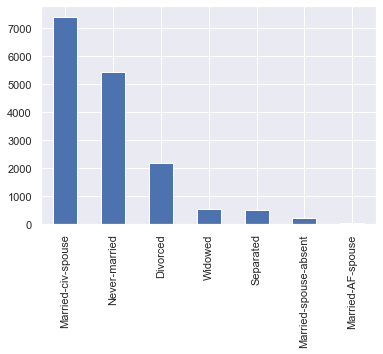

In [19]:
# no surprises here
adultTest["maritalStatus"].value_counts().plot(kind="bar")

<AxesSubplot:>

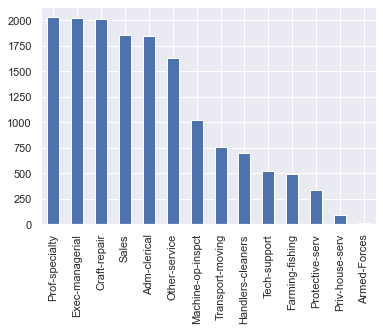

In [20]:
# no surprises here
adultTest["occupation"].value_counts().plot(kind="bar")

<AxesSubplot:>

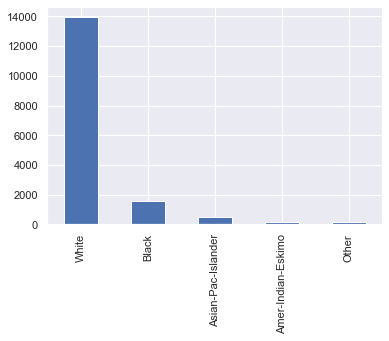

In [21]:
# no surprises here
adultTest["race"].value_counts().plot(kind="bar")

<AxesSubplot:>

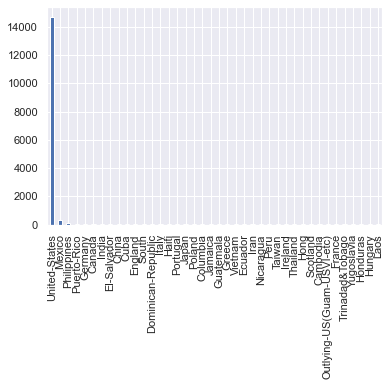

In [22]:
# no surprises here
adultTest["country"].value_counts().plot(kind="bar")

## Plots of target vs features

### Numerical features

In [23]:
## OBS: the plots below dont consider the dataset imbalaca, therefore, all ratios are essentially multiplied
# by a factor of 2.3 in favour of <50K.

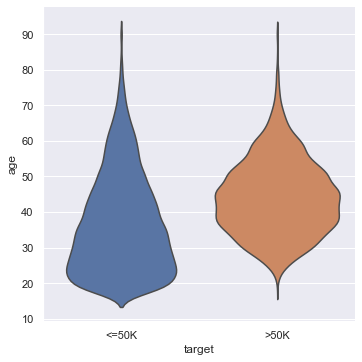

In [24]:
# for <30 it is almost certain that wage <50K; 30-40 roughly the same; 40-50 >50K has good advantage
# <50K decays linearly with age, while 50K is like a normal function centered in 43
sns.catplot(x="target", y="age", kind="violin", inner=None, data=adultTrain)

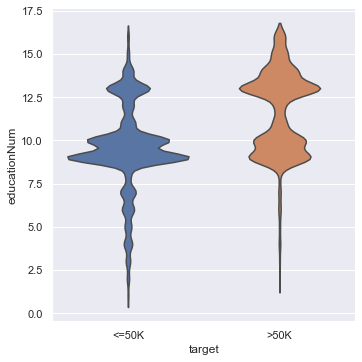

In [25]:
# for <10 <50K has a good advantage; 10-12.5 same; >12.5 >50K has very good advantage
sns.catplot(x="target", y="educationNum", kind="violin", inner=None, data=adultTrain)

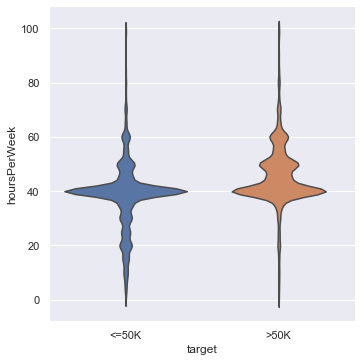

In [26]:
# for <40 <50K has a good advantage; for >40 >50K has a good advantage
sns.catplot(x="target", y="hoursPerWeek", kind="violin", inner=None, data=adultTrain)

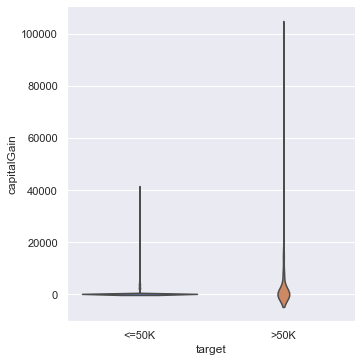

In [27]:
sns.catplot(x="target", y="capitalGain", kind="violin", inner=None, data=adultTrain)

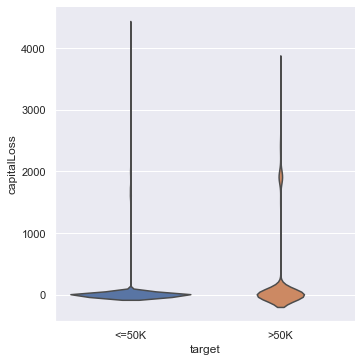

In [28]:
sns.catplot(x="target", y="capitalLoss", kind="violin", inner=None, data=adultTrain)

### Categorical features

In [29]:
# OBS: I am multiplying the counts of >50K by the imbalaceRatio to decouple 
# the fact that the dataset is imbalaced from differences in distribution of the feature

<AxesSubplot:xlabel='target'>

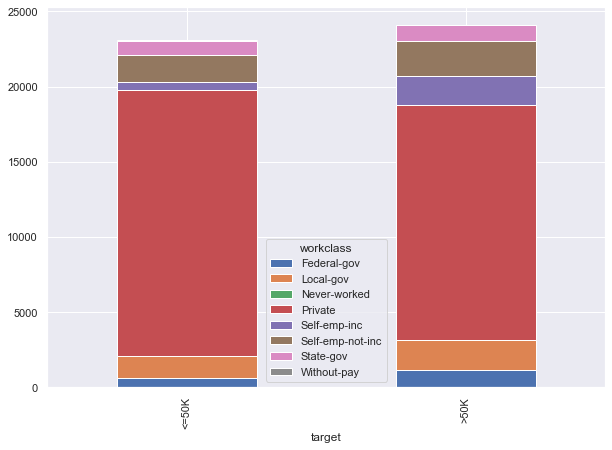

In [30]:
# Private & Self-empinc differ a little, the rest is roughly the same, so can be grouoed 
# into a single category called other
countsDf = adultTrain[["target","workclass"]].value_counts().unstack()
countsDf.loc[">50K", :] = countsDf.loc[">50K", :]*imbalanceRatio
countsDf.plot(kind="bar", stacked=True,  figsize=(10, 7))

<AxesSubplot:xlabel='target'>

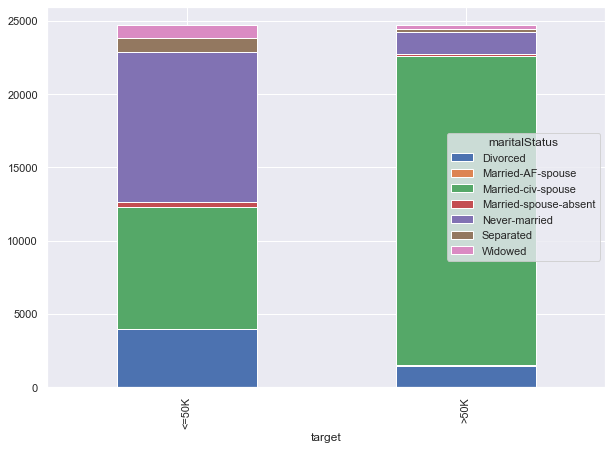

In [31]:
# all ctegories are different, thus maintaining all of them seems the way to go
countsDf = adultTrain[["target","maritalStatus"]].value_counts().unstack()
countsDf.loc[">50K", :] = countsDf.loc[">50K", :]*imbalanceRatio
countsDf.plot(kind="bar", stacked=True,  figsize=(10, 7))

<AxesSubplot:xlabel='target'>

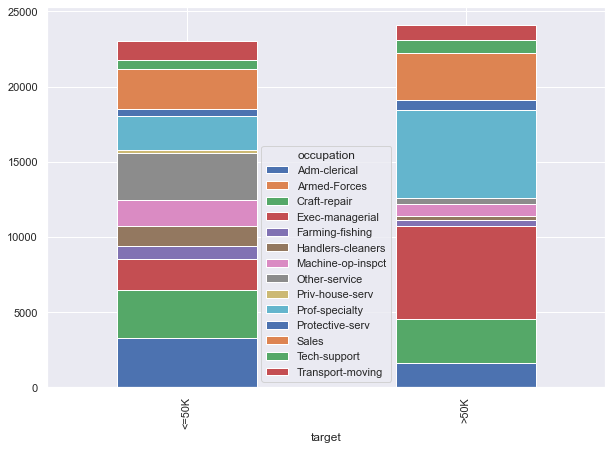

In [32]:
# tranposrt moving, tech support, sales, creaf repair dont seem to help distringuish, so could be grouped
# into a single category named rest
countsDf = adultTrain[["target","occupation"]].value_counts().unstack()
countsDf.loc[">50K", :] = countsDf.loc[">50K", :]*imbalanceRatio
countsDf.plot(kind="bar", stacked=True,  figsize=(10, 7))

<AxesSubplot:xlabel='target'>

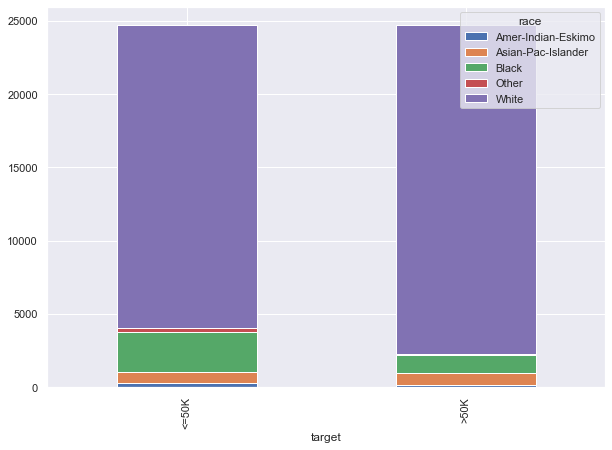

In [33]:
# black and other dimishes for over >50K but white dominates in both
# I think grouping into white and non-white is a valid approach here
countsDf = adultTrain[["target","race"]].value_counts().unstack()
countsDf.loc[">50K", :] = countsDf.loc[">50K", :]*imbalanceRatio
countsDf.plot(kind="bar", stacked=True,  figsize=(10, 7))

<AxesSubplot:xlabel='target'>

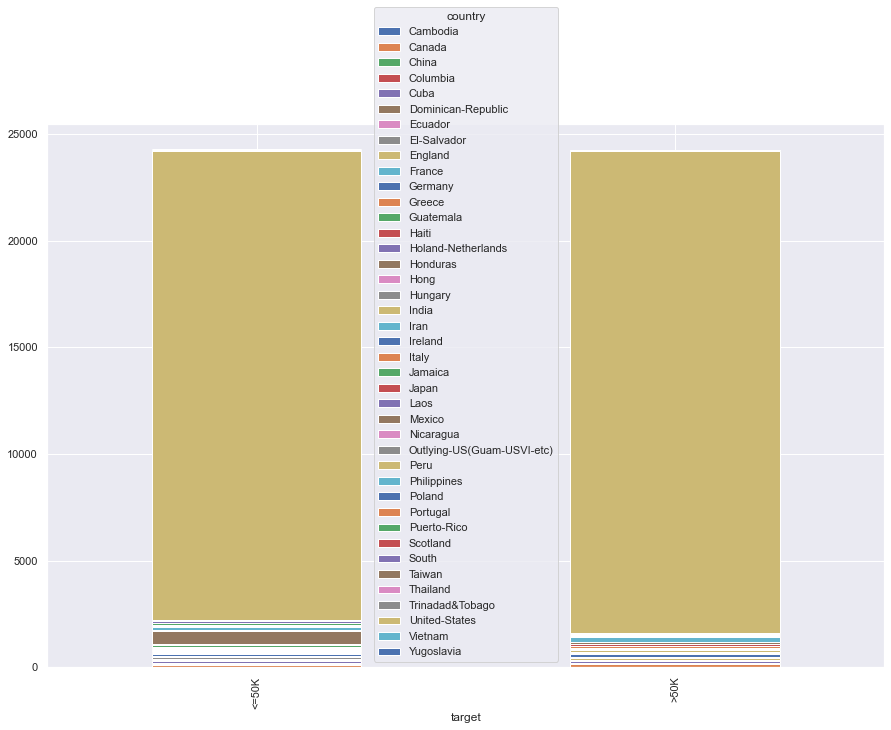

In [34]:
# i think this can be mexico and non-mexico because the rest of the categories have so little data
# that it is likely that we are fittng statistical noise
countsDf = adultTrain[["target","country"]].value_counts().unstack()
countsDf.loc[">50K", :] = countsDf.loc[">50K", :]*imbalanceRatio
countsDf.plot(kind="bar", stacked=True,  figsize=(15, 10))

## Pairwise plots

### Numerical vs numerical

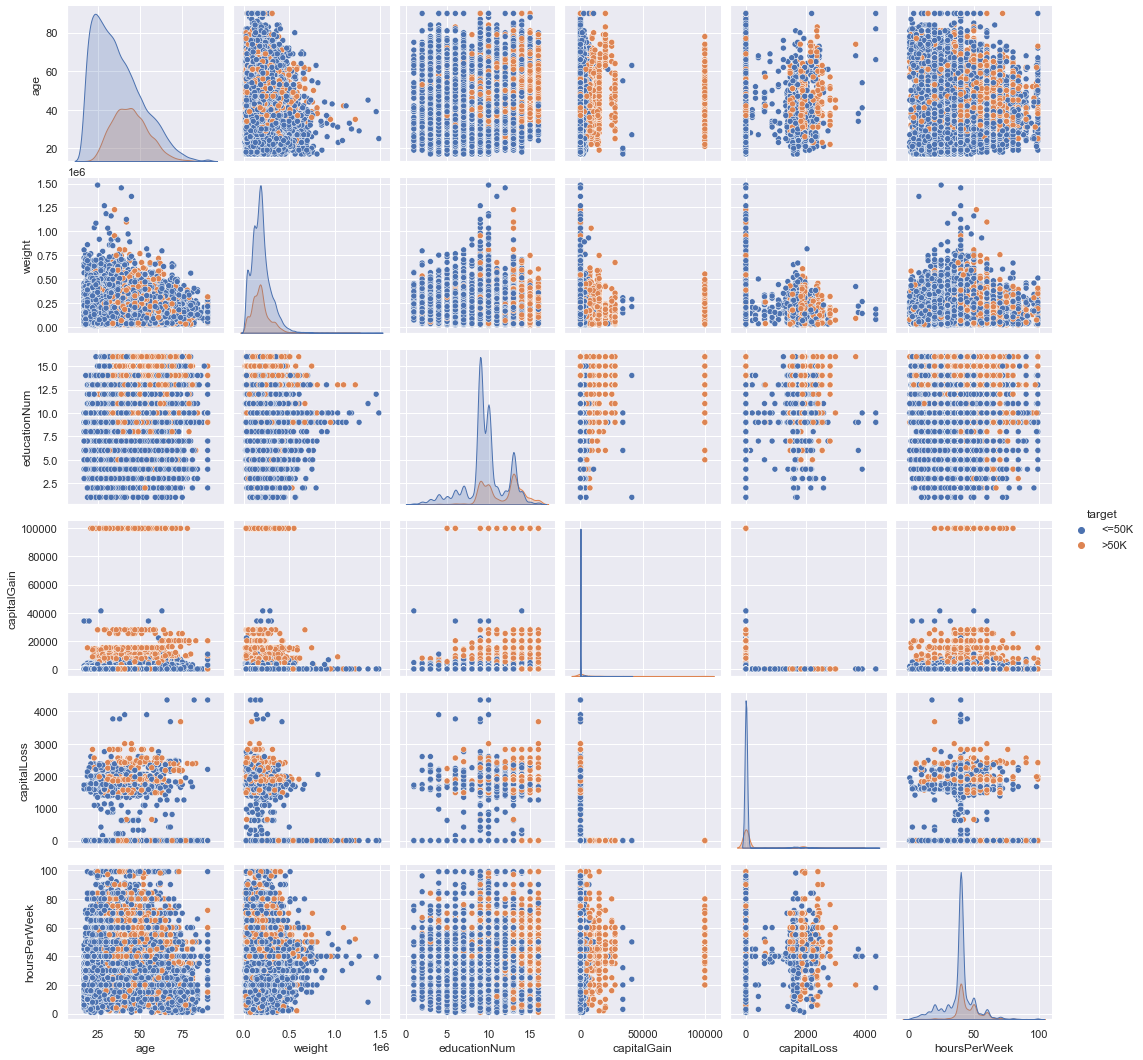

In [35]:
# age limmits >50K even with high education and hours per week
# age < 35 seems to be good indicator -> could maybe be binary variable

# capitalGain > aprox 5 000 seems to be a great separator 
# capitalGain > 50 000 guarantees >50K 
# could be categorical variable

# educationNum > 10 seems to be good indicator also
 
# 1 000 < capital loss < 3 000 can be good 

# hours per week < 50 good
sns.pairplot(adultTrain, hue="target")

## Correlation plot

<AxesSubplot:>

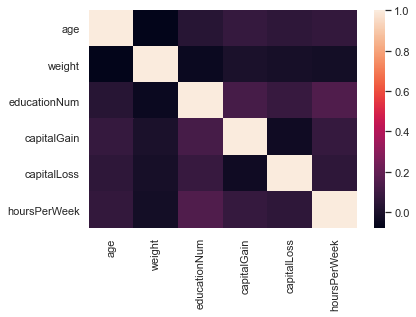

In [36]:
# all numerical features with very low correlation
sns.heatmap(adultTrain.corr())

## Categorical heatmap

In [37]:
adultTrainDummies = pd.get_dummies(adultTrain[["workclass", "maritalStatus", "occupation", "race", "country"]])
dummy_features = adultTrainDummies.columns.values
pivots = []
for feature in dummy_features:
    rest_of_features = dummy_features[dummy_features != feature]
    new_pivot = adultTrainDummies.groupby(feature)[rest_of_features].sum().fillna(0)
    pivots.append(new_pivot)

fullPivot = pd.concat(pivots)[dummy_features]
fullPivotOnes = fullPivot.iloc[lambda x: x.index > 0]
fullPivotOnes.set_index(adultTrainDummies.columns, inplace=True)

def normalize_pivot_tables(fullPivot):
    vec = np.array(fullPivot.sum(axis=1).values)
    sizeDummies = vec.size
    normMatrix = np.zeros((sizeDummies, sizeDummies))
    for i, element in enumerate(vec):
        for j, element2 in enumerate(vec):
            normMatrix[i][j] = element + element2
                        
    normDf = pd.DataFrame(normMatrix, columns=fullPivot.columns)
    normDf.set_index(fullPivot.columns, inplace=True)
    fullPivotNorm = fullPivot.div(normDf)
    return fullPivotNorm

fullPivotNorm = normalize_pivot_tables(fullPivotOnes) # P(X1 = 1, X2 = 1)

# dataset is too big, so will divide in two for plotting heatmaps
#fullPivot2 = fullPivot.iloc[37:, :37] # down left -> not useful
#fullPivot4 = fullPivot.iloc[37:, 37:] # down right -> country vs country -> not useful
fullPivotNorm1 = fullPivotNorm.iloc[:37, :37] # top left
fullPivotNorm3 = fullPivotNorm.iloc[:37:, 37:] # top right

#OBS: dummy features with same prefix are mutually exclsusive, 
# therefore they will have joint prob equal to zero 

# max joint probability is aprox 0.1 in entire categorical combinations dataset, 
# therefore all categorical features are relatively independent from each other


In [38]:
fullPivotNorm.describe()

,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,maritalStatus_Divorced,maritalStatus_Married-AF-spouse,...,country_Portugal,country_Puerto-Rico,country_Scotland,country_South,country_Taiwan,country_Thailand,country_Trinadad&Tobago,country_United-States,country_Vietnam,country_Yugoslavia
count,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,...,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000
mean,0.001949,0.003109,0.000006,0.008761,0.001783,0.003254,0.002262,0.000070,0.004299,0.000051,...,0.000101,0.000561,0.000030,0.000444,0.000272,0.000139,0.000082,0.009622,0.000353,0.000034
std,0.003225,0.006019,0.000026,0.019719,0.003597,0.006387,0.004026,0.000234,0.007716,0.000123,...,0.000195,0.001755,0.000072,0.002125,0.001370,0.000517,0.000209,0.021478,0.001802,0.000077
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000117,0.000000,0.000177,0.000000,0.000098,0.000000,0.000000,0.000113,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000470,0.000348,0.000000,0.000618,0.000402,0.000473,0.000366,0.000000,0.000341,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.002424,0.002955,0.000000,0.006179,0.001474,0.002088,0.002307,0.000000,0.004434,0.000000,...,0.000144,0.000722,0.000000,0.000242,0.000014,0.000014,0.000067,0.008238,0.000184,0.000000
max,0.016817,0.028423,0.000167,0.098834,0.019406,0.030512,0.019143,0.001490,0.031843,0.000767,...,0.000893,0.014325,0.000379,0.018139,0.011625,0.003987,0.001328,0.115823,0.015458,0.000308


<AxesSubplot:>

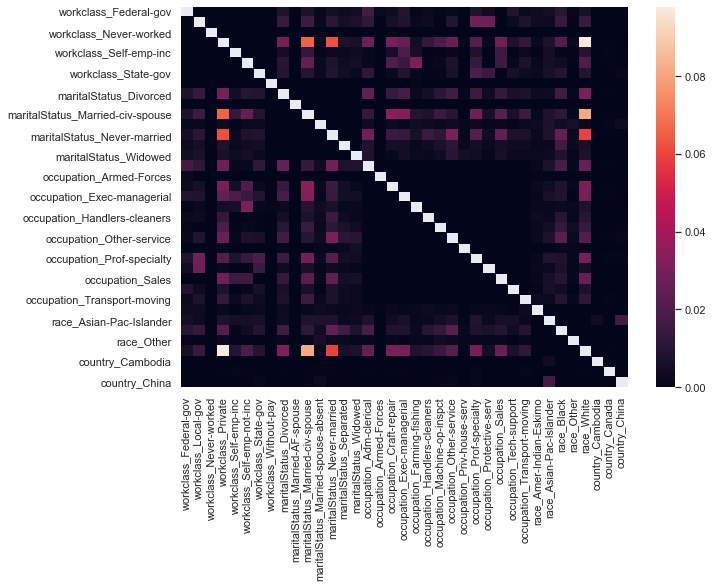

In [39]:
_, ax = plt.subplots(figsize=(10,7))
sns.heatmap(fullPivotNorm1,ax=ax)

<AxesSubplot:>

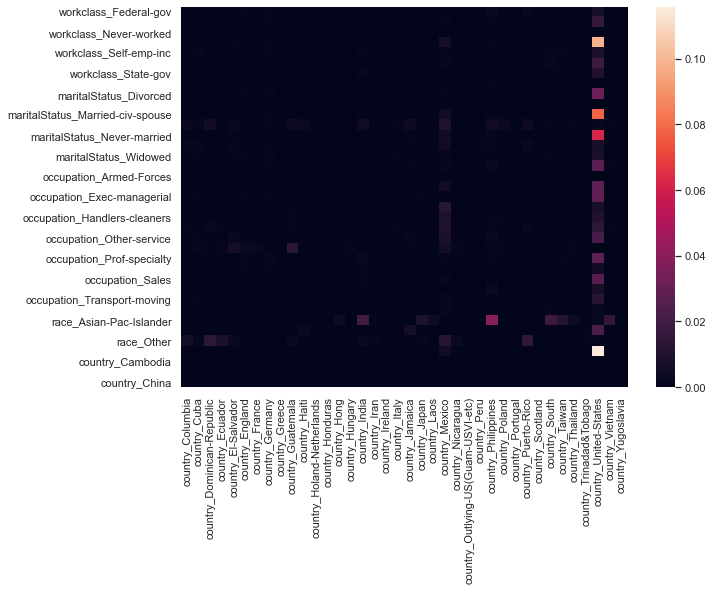

In [40]:
_, ax = plt.subplots(figsize=(10,7))
sns.heatmap(fullPivotNorm3, ax=ax)

# Data engineering
### Prepare data for algorithm.

## Divide dataset into numerical and categorical subdatasets

In [41]:
numColumns = ["age", "capitalGain", "capitalLoss", "educationNum", "hoursPerWeek"] # obs: left weight out
catColumns = ["country", "education", "maritalStatus", "occupation", "race", "relationship", "sex", "workclass"] # obs: left target out
targetTrain = adultTrain["target"]
adultTrainNum = adultTrain[numColumns]
adultTrainCat = adultTrain[catColumns]

In [42]:
adultTrainNum.head()

,age,capitalGain,capitalLoss,educationNum,hoursPerWeek
0,34,0,0,10,44
1,58,0,0,6,40
2,25,0,0,10,42
3,24,0,0,10,40
4,57,5178,0,9,60


In [43]:
adultTrainCat.head()

,country,education,maritalStatus,occupation,race,relationship,sex,workclass
0,United-States,Some-college,Divorced,Exec-managerial,White,Own-child,Male,Private
1,United-States,10th,Married-civ-spouse,Transport-moving,White,Husband,Male,Local-gov
2,United-States,Some-college,Never-married,Machine-op-inspct,White,Not-in-family,Male,Private
3,United-States,Some-college,Divorced,Adm-clerical,White,Not-in-family,Female,Private
4,Hungary,HS-grad,Married-civ-spouse,Transport-moving,White,Husband,Male,Self-emp-inc


## Normalize features

In [44]:
adultTrainNum = (adultTrainNum-adultTrainNum.mean())/adultTrainNum.std()
adultTrainNum.head()

,age,capitalGain,capitalLoss,educationNum,hoursPerWeek
0,-0.335881,-0.145911,-0.21666,-0.031325,0.288520
1,1.423567,-0.145911,-0.21666,-1.586106,-0.035429
2,-0.995674,-0.145911,-0.21666,-0.031325,0.126545
3,-1.068984,-0.145911,-0.21666,-0.031325,-0.035429
4,1.350257,0.555201,-0.21666,-0.420020,1.584316


## Treat categorical features

In [45]:
# Target-encoding 
# encoder = TargetEncoder()
# encoder.fit_transform(adultTrainCat, adultTrain["target"])
# Simple one-hot encoding (this will be chosen one for now)
adultTrainCat = pd.get_dummies(adultTrainCat)
adultTrainCat.head()

,country_Cambodia,country_Canada,country_China,country_Columbia,country_Cuba,country_Dominican-Republic,country_Ecuador,country_El-Salvador,country_England,country_France,...,sex_Female,sex_Male,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


## Joining numerical and categorical dfs back

In [46]:
adultTrain = pd.concat([adultTrainNum, adultTrainCat], axis=1)
adultTrain.head()

,age,capitalGain,capitalLoss,educationNum,hoursPerWeek,country_Cambodia,country_Canada,country_China,country_Columbia,country_Cuba,...,sex_Female,sex_Male,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay
0,-0.335881,-0.145911,-0.21666,-0.031325,0.288520,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,1.423567,-0.145911,-0.21666,-1.586106,-0.035429,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
2,-0.995674,-0.145911,-0.21666,-0.031325,0.126545,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,-1.068984,-0.145911,-0.21666,-0.031325,-0.035429,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,1.350257,0.555201,-0.21666,-0.420020,1.584316,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


## Treat missing values

In [47]:
# Two main options
# 1. Just thorw away rows with missing values
# 2. Replace with mean of colummn (this will be chosen one for now)
adultTrain.fillna(adultTrain.mean(), inplace=True)

## Treat outliers

In [48]:
# Outliers don't mess much with KNN, since we we only looking to locally close points, so won't be necessary

## Feature tranformations

In [49]:
# knn classiffier distance metric and algorithm can do this job already

## Mirror on test dataset

In [50]:
adultTestNum = adultTest[numColumns]
adultTestCat = adultTest[catColumns]

adultTestNum = (adultTestNum-adultTestNum.mean())/adultTestNum.std() # broadcasts to columns by default

adultTestCat = pd.get_dummies(adultTestCat)
adultTestCat = adultTestCat.reindex(columns = adultTrainCat.columns, fill_value=0) # equivalent to fit transform

adultTest = pd.concat([adultTestNum, adultTestCat], axis=1)

adultTest.fillna(adultTest.mean(), inplace=True)

adultTest.head()

,age,capitalGain,capitalLoss,educationNum,hoursPerWeek,country_Cambodia,country_Canada,country_China,country_Columbia,country_Cuba,...,sex_Female,sex_Male,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay
0,-0.994159,-0.142662,-0.218062,1.139977,0.289088,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,1.821889,-0.142662,-0.218062,1.139977,0.369218,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,-0.560921,-0.142662,-0.218062,1.529459,-0.031432,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
3,0.449968,-0.142662,-0.218062,-0.417952,-0.031432,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,1.821889,-0.142662,-0.218062,1.139977,0.769868,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


# Feature Engineering
### Select and/or create new features. Non-linear transformations affect more KNN performance

In [51]:
# Primising Engineered Datasets (v0)
# Disct which will hold different feature engineered candidate datsets
promisingDatasets = {}

## Importance sampling

In [52]:
############### NOTEBOOK WAS TO SLOW WITH THIS, DECIDED TO COMMENT OUT ###################

# # with the given weights, the rows can be resampled according to their weight
# # number of rows = weight_factor*minMaxNormalized_weight where the weight factor is large enough so that the sampling
# # can give different integer values for most of the rows, 
# # but if it is too large becomes computationally heavy
# weightTrainNorm = ((weightTrain) - weightTrain.min())/(weightTrain.max() - weightTrain.min())
# weightFactor = 50 # (can be altered later)
# knnNeighboursFactor = weightTrainNorm.mean()*50 # expected value of number of columns added
# print('knnNeighboursFactor:', knnNeighboursFactor)

# # adultTrain70Importance will contain replicas only of row in it, will used to train KNN, 
# # that will be tested in adultTrain30ImportanceCV, which wasnt replicated
# adultTrainShuffled = adultTrain.sample(frac=1)
# adultTrain70Importance, adultTrain30Importance = \
#     np.split(adultTrainShuffled, [int(.7*len(adultTrain))])
# adultTrain30ImportanceCopy = adultTrain30Importance.copy()
# # putting back target I removed earlier
# adultTrain70Importance["target"] = targetTrain[:len(adultTrain70Importance)]

# for idx, row in adultTrain70Importance.iterrows():
#     numReplicatedRows = int(weightTrainNorm[idx]*weightFactor)
#     df = row.to_frame().T
#     adultTrain70Importance = adultTrain70Importance.append([df]*numReplicatedRows, ignore_index=True)
    
# for idx, row in adultTrain30ImportanceCopy.iterrows():
#     numReplicatedRows = int(weightTrainNorm[idx]*weightFactor)
#     df = row.to_frame().T
#     adultTrain30ImportanceCopy = adultTrain30ImportanceCopy.append([df]*numReplicatedRows, ignore_index=True)

# #### IMPORTANT: this is 100% of the actual training dataset -> only used if survived CV
# adultTrainImportance = pd.concat([adultTrain70Importance, adultTrain30ImportanceCopy])
# promisingDatasets["importanceSampling"] = adultTrainImportance

## Select features

In [53]:
# Didn't have time to do, will finish later

## Create new features

In [54]:
# Didn't have time to do, will finish later

# Experiments
### Train on different datasets, try different hyperparameters for KNN.

In [55]:
# Label encoder
le = preprocessing.LabelEncoder()
# Test data
Xtest = adultTest.values

## Base dataset

In [56]:
#### Baseline dataset
Xtrain = adultTrain.values
Ytrain = le.fit_transform(targetTrain)

# shape check
print(Xtrain.shape)
print(Xtest.shape)
print(Ytrain.shape)

(32560, 104)
(16280, 104)
(32560,)


## Baseline

In [57]:
baselineKnn = KNeighborsClassifier()
baselineKnnAcc = cross_val_score(baselineKnn, Xtrain, Ytrain, cv=10, scoring='accuracy')
baselineKnnAccMean = baselineKnnAcc.mean()
print('mean accuracy for baselineKnnMean: ', baselineKnnAccMean)

currentBestModel = {
    'model': copy.deepcopy(baselineKnn), 
    'cv': baselineKnnAccMean, 
    'X': Xtrain,
    'Y': Ytrain
}

mean accuracy for baselineKnnMean:  0.8359643734643735


## Hyperparameter tuning

### # Neighbors parameter

In [58]:
neighbours3Knn = KNeighborsClassifier(n_neighbors=3)
neighbours3KnnAcc = cross_val_score(neighbours3Knn, Xtrain, Ytrain, cv=10, scoring='accuracy')
neighbours3KnnAccMean = neighbours3KnnAcc.mean()
print('mean accuracy for neighbours3KnnMean: ', neighbours3KnnAccMean)

if neighbours3KnnAccMean > currentBestModel['cv']:
    currentBestModel = {
        'model': neighbours3Knn,
        'cv': neighbours3KnnAccMean
    }

mean accuracy for neighbours3KnnMean:  0.8278869778869777


### Distance type parameter

In [59]:
distanceManhattanKnn = KNeighborsClassifier(metric="manhattan")
distanceManhattanKnnAcc = cross_val_score(distanceManhattanKnn, Xtrain, Ytrain, cv=10, scoring='accuracy')
distanceManhattanKnnAccMean = distanceManhattanKnnAcc.mean()
print('mean accuracy for distanceManhattanKnnMean: ', distanceManhattanKnnAccMean)

if distanceManhattanKnnAccMean > currentBestModel['cv']:
    currentBestModel = {
        'model': distanceManhattanKnn,
        'cv': distanceManhattanKnnAccMean
    }

mean accuracy for distanceManhattanKnnMean:  0.8336916461916463


### Distance weights parameters

In [60]:
weightsDistanceKnn = KNeighborsClassifier(weights="distance")
weightsDistanceKnnAcc = cross_val_score(weightsDistanceKnn, Xtrain, Ytrain, cv=10, scoring='accuracy')
weightsDistanceKnnAccMean = weightsDistanceKnnAcc.mean()
print('mean accuracy for weightsDistanceKnnMean: ', weightsDistanceKnnAccMean)

if weightsDistanceKnnAccMean > currentBestModel['cv']:
    currentBestModel = {
        'model':weightsDistanceKnn,
        'cv': weightsDistanceKnnAccMean
    }

mean accuracy for weightsDistanceKnnMean:  0.8288390663390665


## Engineered datasets

In [61]:
############### NOTEBOOK WAS TO SLOW WITH THIS, DECIDED TO COMMENT OUT ###################

# # 1. Importance Sampling dataset
# Ytrain70ImportanceNotEncoded = adultTrain70Importance.pop("target").values
# print('Ytrain70ImportanceNotEncoded:', Ytrain70ImportanceNotEncoded) 
# Ytrain70Importance = le.fit_transform(Ytrain70ImportanceNotEncoded)
# print('Ytrain70Importance:', Ytrain70Importance) ## remove afterwards
# Xtrain70Importance = adultTrain70Importance.values

# # for cross validation 
# # k-fold cross validation is not done here because, the duplicated rows would leak to the cv sets
# #Ytrain30ImportanceNotEncoded = adultTrain30Importance.pop("target")
# Ytrain30Importance = le.fit_transform(Ytrain30ImportanceNotEncoded)
# Xtrain30Importance = adultTrain30Importance.values

# # shape check
# print(Xtrain70Importance.shape)
# print(Xtest.shape) 
# print(Ytrain70Importance.shape)

# # 5 is the deafult n_neighbors
# importanceSamplingKnn = KNeighborsClassifier(n_neighbors=int(5*knnNeighboursFactor))
# importanceSamplingKnn.fit(Xtrain70Importance, Ytrain70Importance)
# Ytrain30Prediction = importanceSamplingKnn.predict(Xtrain30Importance)
# print('Ytrain30Prediction', Ytrain30Prediction) ### remove afterwards
# importanceSamplingKnnAccMean = accuracy_score(Ytrain30Importance, Ytrain30Prediction)

# print('mean accuracy for importanceSamplingKnnAccMean: ', importanceSamplingKnnAccMean)
# if importanceSamplingKnnAccMean > currentBestModel['cv']:  
#     # get whole dataset fro promisingDatasets
#     adultTrainImportance = promisingDatasets["importanceSampling"] 
    
#     YtrainImportance = le.fit_transform(adultTrainImportance.pop("target").values)
#     XtrainImportance = adultTrainImportance.values
        
#     currentBestModel = {
#         'model': importanceSamplingKnn,
#         'cv': importanceSamplingKnnAccMean,
#         'X': XtrainImportance,
#         'Y': YtrainImportance
#     }

# Final model
### Trained on entire train dataset.

In [62]:
model = currentBestModel['model']
X = currentBestModel['X']
Y = currentBestModel['Y']
model.fit(X, Y)
predictions = model.predict(Xtest) # numpy array
print(predictions)

[0 0 1 ... 0 0 1]


# Submission
### Save to csv in the required format.

In [63]:
# going back to array of strings <=50 K and >50K
predictions = le.inverse_transform(predictions)
submissionDf = pd.DataFrame({'Id': idTest.values, 'income': predictions})

submissionDf.to_csv("submission.csv", index=False)